# **Y**-**M**odel for **C**lassification : **A**NAGEO

## Importing libraries

In [1]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dot, Add

In [2]:
import pandas as pd
import numpy as np

In [3]:
from tensorflow.keras.layers import BatchNormalization

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras.optimizers import SGD, Adam

In [6]:
import tensorflow as tf

In [7]:
import h5py
import os, sys

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Function python

In [9]:
def import_hf5(data_path, data_name, get_name):
    hf = h5py.File(os.path.join(data_path, data_name), mode="r")
    data = hf.get(get_name)
    stack = np.array(data)
    hf.close()
    return stack

In [10]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    stack = image_data
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

In [11]:
def make_csv(predict, patch_id_raster, name):
    import csv
    #reshape the prediction list that contains probability and convert into list
    predict = predict.reshape(1,predict.size).tolist()[0]  
    
    header = ['prob_slum','id'] #create header (name of variables)
    cont = []  #initialise list
    cont.append(header)
    for x,y in zip(predict,patch_id_raster):
        current_row = [x,y[0]] 
        cont.append(current_row) #append the probability and its corresponding id

    cont

    with open(str(name)+'.csv','w') as file :
        write = csv.writer(file) #save the list in the CSV file
        write.writerows(cont)

In [12]:
'''
Reshaping function to invert the size of the list
'''
def reshape(list_input):
    L = np.array(list_input)
    L = L.reshape(L.size,-1)
    
    return L

### Importing modules from SRC

In [13]:
# Add local module to the path
src = os.path.abspath('SRC/')
if src not in sys.path:
    sys.path.append(src)


In [14]:
print(sys.path)

['/home/jgovoort', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/jgovoort/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/jgovoort/SRC']


### Importing modules from Modules

In [15]:
# Add local module to the path
src = os.path.abspath('Modules/')
if src not in sys.path:
    sys.path.append(src)


In [16]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train, plot_loss_multirun
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file
# Import LRFinder function
from LRFinder import LRFinder

In [17]:
from PlotHistories import plotandcsv_history_kfold

from stackage import stackage

from CircleMaker import circle

from assimilation import assimilation

## **Preprocessing** : Importing the training and validation samples ID from a CSV

In [18]:
data= pd.read_csv("Nairobi_10Fold_Split.csv")
data

,kfold,ID_train,ID_val
0,1,"[10508, 10509, 10763, 10767, 11016, 11017, 112...","[10255, 16578, 17321, 17338, 17596, 17850, 181..."
1,2,"[10255, 10508, 10509, 10763, 10767, 11016, 112...","[11017, 14525, 15571, 16579, 16834, 17088, 175..."
2,3,"[10255, 10508, 10509, 10763, 11016, 11017, 112...","[10767, 11270, 11523, 11776, 16305, 16580, 168..."
3,4,"[10255, 10508, 10767, 11017, 11270, 11275, 115...","[10509, 10763, 11016, 12533, 14023, 15572, 168..."
4,5,"[10255, 10509, 10763, 10767, 11016, 11017, 112...","[10508, 11275, 11781, 12795, 14021, 14022, 142..."


## **Model definition**

In [36]:
def ymodel(left_input_shape,right_input_shape,batch_size,kernel_size,dropout,n_filters,stack_train,stack_test,stack_sar_train,stack_sar_test,fold):
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = {}):
            if logs.get('val_accuracy') > 0.98:
              print("\n Enough accuracy")
              self.model.stop_training = True

    maxcallbacks = myCallback()
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min')
    #Defining the callbacks
    myCallbacks = [#tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/checkpoint_'+str(IMAGENAME[path])+'_'+str(fold+1), save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
                   maxcallbacks, 
                   tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001) ]
    
    #Left branch
    
    right_inputs = Input(shape=right_input_shape)
    y = right_inputs
    
    left_inputs = Input(shape=left_input_shape)
    x = left_inputs

    #Merging the two inputs to apply the same data augmentation
    aug = concatenate([x,y])
    #Data augmentation
    aug = RandomFlip("horizontal_and_vertical")(aug)
    aug = RandomRotation(0.2, fill_mode='reflect')(aug)
    #x = RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect')(x) 
    
    #Split the aug layer to correspond to the initial inputs
    x = tf.keras.layers.Lambda(lambda x : x[:,:,:,0:4])(aug)
    y = tf.keras.layers.Lambda(lambda x : x[:,:,:,4:8])(aug)
    
    print(x.shape)
    print(y.shape)
    
    # Left branch
    
    # 2 layer of Conv2D-Dropout-MaxPooling2D
    filters = n_filters
    
    for i in range(2):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding='same',
                   activation='relu')(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(dropout)(x)
        filters *= 2
        
    x = MaxPooling2D()(x)

    #Right branch
    
    # 2 layer of Conv2D-Dropout-MaxPooling2D
    filters = n_filters
    
    for i in range(2):
        y = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding='same',
                   activation='relu')(y)
        y = BatchNormalization(axis=-1)(y)
        y = Dropout(dropout)(y) 
        filters *= 2

    y = MaxPooling2D()(y)
       
    
    # merge left and right branches outputs
    z = concatenate([x, y])
    
    # feature maps to vector before connecting to Dense 
    z = Flatten()(z)
    z = Dropout(dropout)(z)
    z = Dense(1024,activation='relu')(z)
    z = Dropout(dropout)(z)
    z = Dense(512,activation='relu')(z)
    
    #Output layer that attributes the probability to be a slum
    outputs = Dense(1, activation="sigmoid")(z)
    
    
    model = Model([left_inputs, right_inputs], outputs)
    
    #Exporting a plot of the model structure    
    tf.keras.utils.plot_model(
                                model,
                                to_file="outputCSV/model.png",
                                show_shapes=True,
                                show_dtype=True,
                                show_layer_names=True,
                                rankdir="TB",
                                expand_nested=False,
                                dpi=96,
                                layer_range=None,
                                show_layer_activations=True,
                                )
    #plotting the specificity of the model 
    model.summary()
    #Compile the model and difining the learning rate
    model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=7e-5),
              metrics=['accuracy'])
    #Model training
    history = model.fit([stack_train, stack_sar_train],
          patch_lulc_train, 
          validation_data=([stack_test, stack_sar_test], patch_lulc_test),
          epochs=200,
          batch_size=batch_size, callbacks=[myCallbacks])
    #Model evaluation with the last epoch
    score = model.evaluate([stack_test, stack_sar_test],
                       patch_lulc_test,
                       batch_size=batch_size,
                       verbose=0)
    #Load the weight of the best epoch in term of validation accuracy
    model.load_weights('checkpoint/checkpoint_'+str(IMAGENAME[path])+'_'+str(fold+1))
    #Evaluation of the model with the weight of the best epoch
    evaluation = model.evaluate([stack_test, stack_sar_test], patch_lulc_test, batch_size=batch_size)
    #Model prediction on all the Grid with the best epoch.
    predict = model.predict([S2_stack_grid, S1_stack_grid])
    
    layers = model.layers


    
    print(score)
    
    return history, predict, layers, model, evaluation

## **Running model** on multiple fold

In [34]:
HISTALL = []
PREDALL = []
EVALALL = []

IMAGESTR = ['Images/big_raster/tr_BNIR_patch/tr_Ymodel_S1BNIR.hdf5','Images/big_raster/tr_RNIR_patch/tr_Ymodel_S1RNIR.hdf5','Images/big_raster/tr_RGBNIR_patch/tr_Ymodel_S1RGBNIR.hdf5']
IMAGESG = ['Images/big_raster/g_BNIR_patch/g_Ymodel_S1BNIR.hdf5','Images/big_raster/g_RNIR_patch/g_Ymodel_S1RNIR.hdf5','Images/big_raster/g_RGBNIR_patch/g_Ymodel_S1RGBNIR.hdf5']
IMAGENAME = ['BNIR','RNIR','RGBNIR']

In [18]:
HISTALL = []
PREDALL = []
EVALALL = []

IMAGESTR = ['Images/big_raster/tr_VVVHBNIR_patch/tr_Ymodel_VVVHBNIR.hdf5','Images/big_raster/tr_VVVHRNIR_patch/tr_Ymodel_VVVHRNIR.hdf5','Images/big_raster/tr_VVVHRGBNIR_patch/tr_Ymodel_VVVHRGBNIR.hdf5']
IMAGESG = ['Images/big_raster/g_VVVHBNIR_patch/g_Ymodel_VVVHBNIR.hdf5','Images/big_raster/g_VVVHRNIR_patch/g_Ymodel_VVVHRNIR.hdf5','Images/big_raster/g_VVVHRGBNIR_patch/g_Ymodel_VVVHRGBNIR.hdf5']
IMAGENAME = ['VVVH_BNIR','VVVH_RNIR','VVVH_RGBNIR']

Images/big_raster/tr_BNIR_patch/tr_Ymodel_S1BNIR.hdf5
Images are imported and normalised


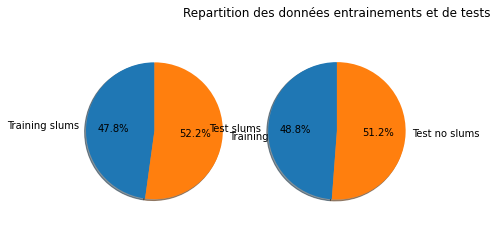

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 573. 1644. 1865. 1969.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_21643_1.tif'
[21643]
[ 860. 1588. 1565. 2317.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_26198_1.tif'
[26198]
[ 713. 2554. 2866. 1834.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_22636_1.tif'
[22636]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.5829633  -5.5321984 -12.845544 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_28202_1.tif'
[28202]
[ 0.4138895 -6.3565474 -6.207988 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_26460_1.tif'
[26460]
[ 0.6578623 -1.1018876 -8.17592  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_63173_1.tif'
[63173]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenate)    

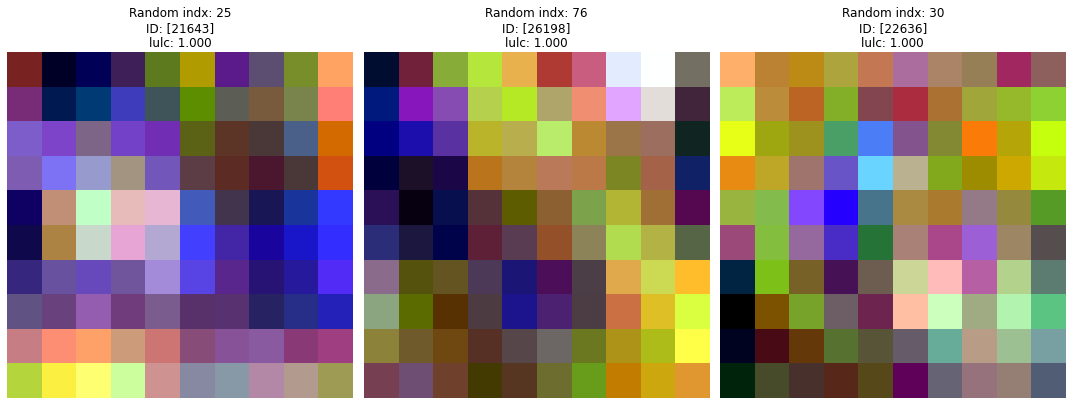

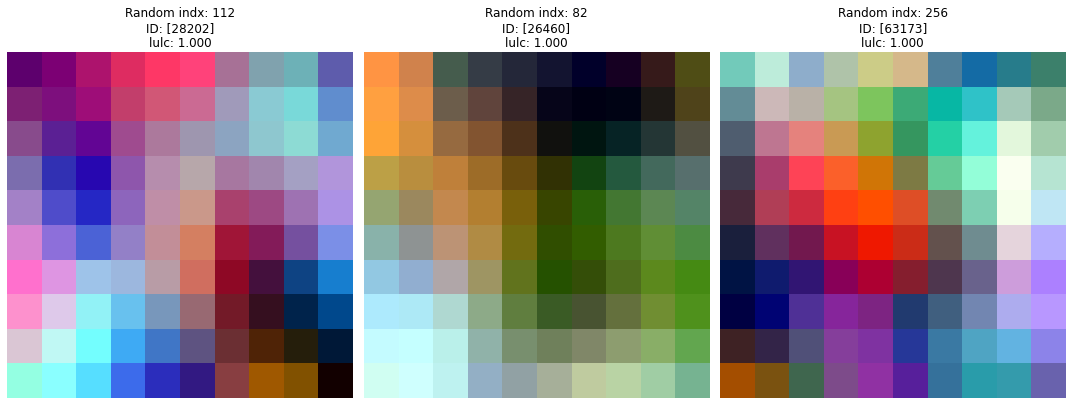

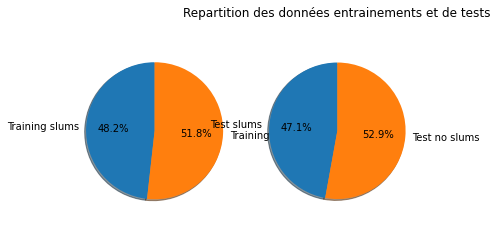

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1234. 1582. 1541. 2231.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_55071_1.tif'
[55071]
[ 670. 1299. 1501. 2077.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_64872_1.tif'
[64872]
[ 847. 2178. 2252. 2052.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_27711_1.tif'
[27711]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.2986418  -8.824217  -14.172148 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_20644_1.tif'
[20644]
[ 0.6598576 -4.543153  -4.187004 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_61356_1.tif'
[61356]
[  0.46323025  -5.983586   -12.843107  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_26716_1.tif'
[26716]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenat

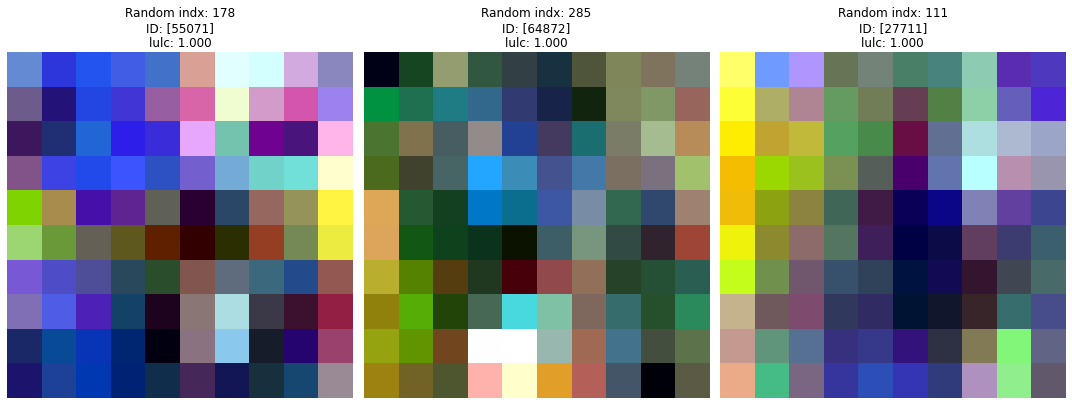

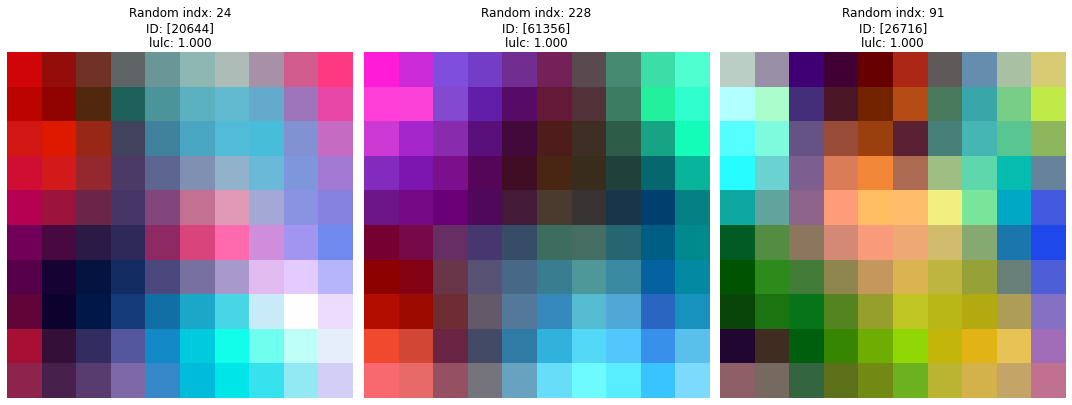

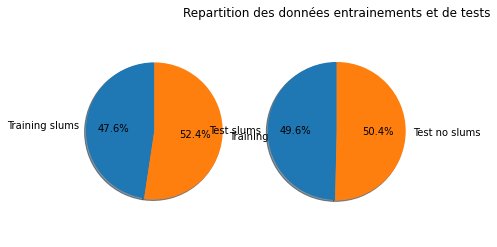

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 959. 1904. 2439. 2001.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_24193_1.tif'
[24193]
[1284. 1641. 1690. 2890.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_57797_1.tif'
[57797]
[ 436. 2376. 2193. 1829.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_19114_1.tif'
[19114]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.40670836 -9.76286    -8.226464  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_62598_1.tif'
[62598]
[  0.6580429  -2.5739465 -10.066238 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_27697_1.tif'
[27697]
[  0.6580429  -2.5739465 -10.066238 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_27697_1.tif'
[27697]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenat

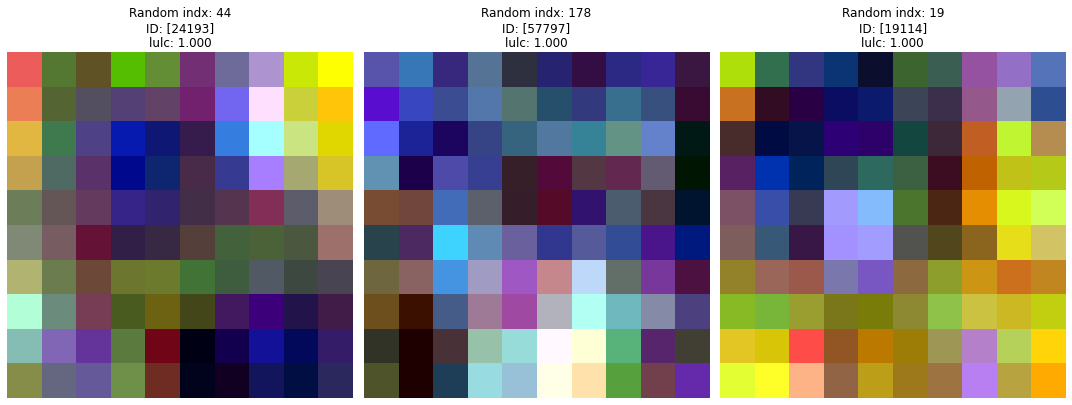

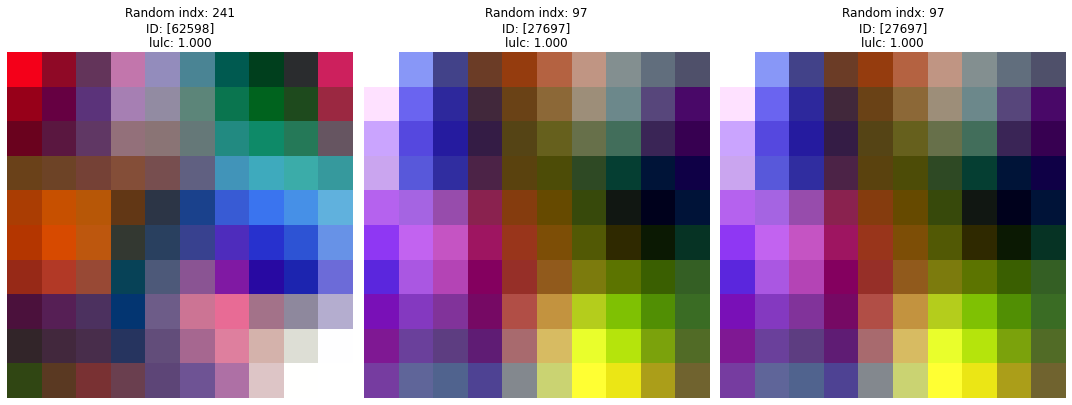

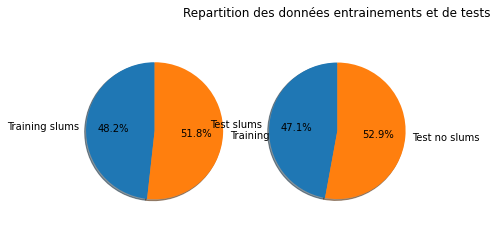

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 635. 1818. 1798. 2147.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_26960_1.tif'
[26960]
[ 547. 2176. 2176. 2017.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_21906_1.tif'
[21906]
[ 982. 1681. 1781. 2382.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_53502_1.tif'
[53502]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.5406583  -9.743012  -14.6340275]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_61076_1.tif'
[61076]
[  0.57875067  -4.4508076  -11.773512  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_63109_1.tif'
[63109]
[  0.5104039  -5.371758  -12.839888 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_25701_1.tif'
[25701]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concate

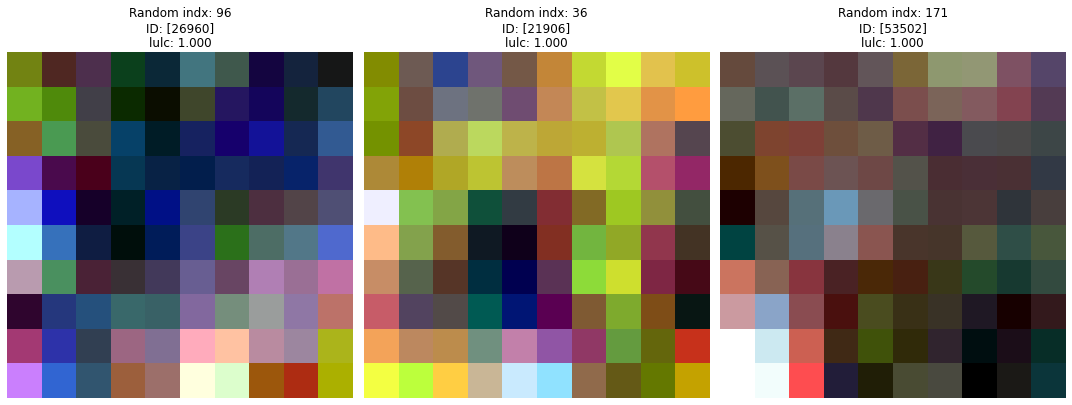

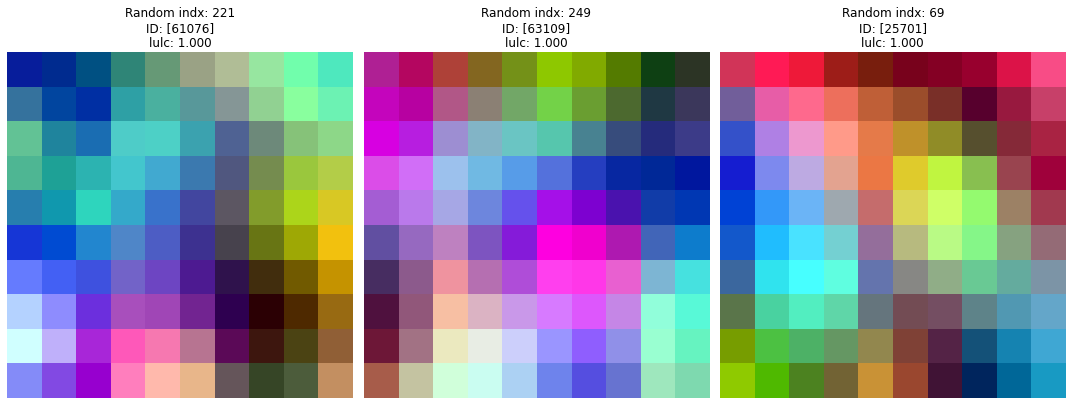

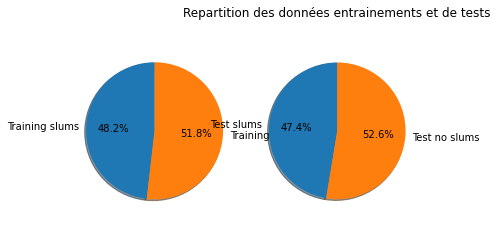

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 957. 1734. 1699. 2012.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_22383_1.tif'
[22383]
[ 978. 1608. 1775. 2409.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_56789_1.tif'
[56789]
[ 568. 2054. 2069. 2101.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_24917_1.tif'
[24917]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.6108667  -6.1493154 -12.155961 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_66639_1.tif'
[66639]
[  0.6372144  -1.9838295 -12.640422 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_65121_1.tif'
[65121]
[  0.50170386  -7.884731   -17.134453  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_24942_1.tif'
[24942]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concate

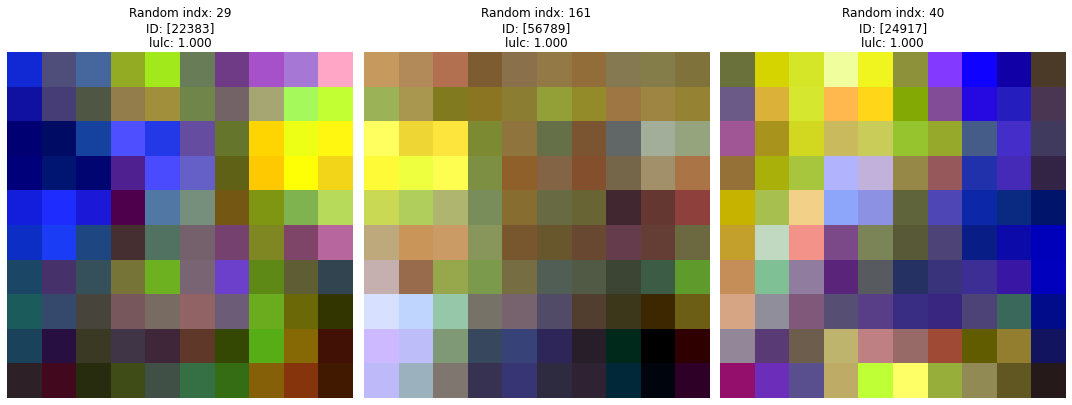

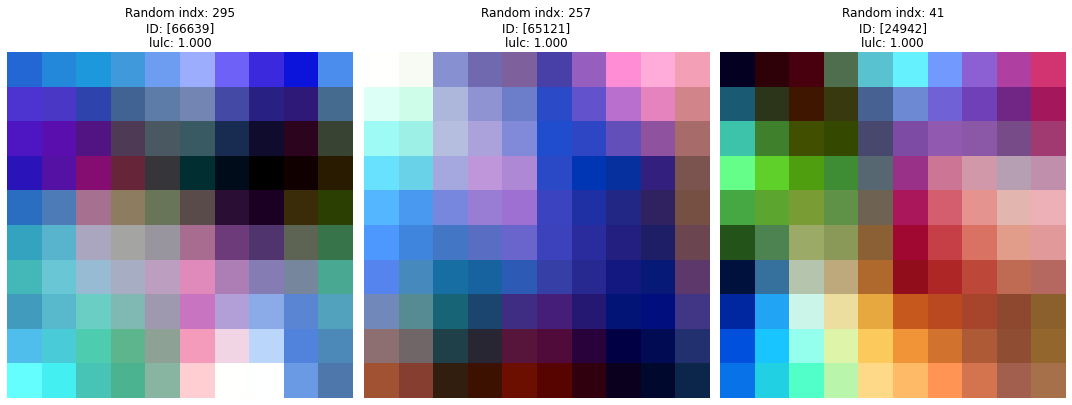

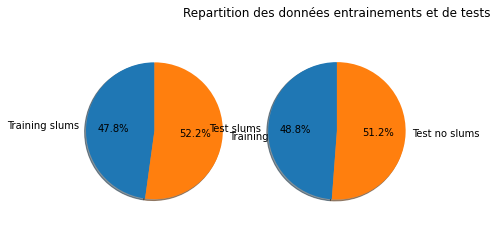

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1584. 1588. 1652. 2556.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_34323_1.tif'
[34323]
[1432. 1606. 1758. 2160.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_28202_1.tif'
[28202]
[1540. 1692. 1810. 2575.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_62087_1.tif'
[62087]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.62413794  -6.464846   -12.292458  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_62918_1.tif'
[62918]
[ 0.56449795 -2.0787437  -9.41365   ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_60578_1.tif'
[60578]
[  0.49040046  -7.646769   -11.008411  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_60570_1.tif'
[60570]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Conc

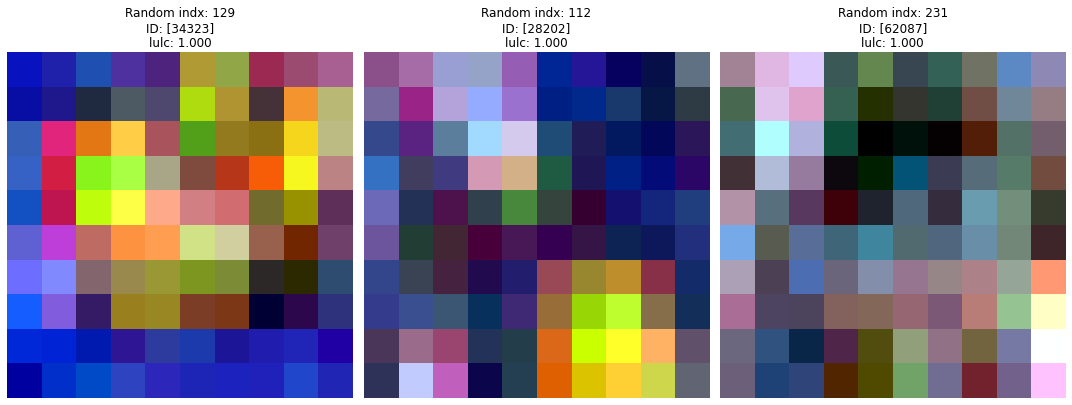

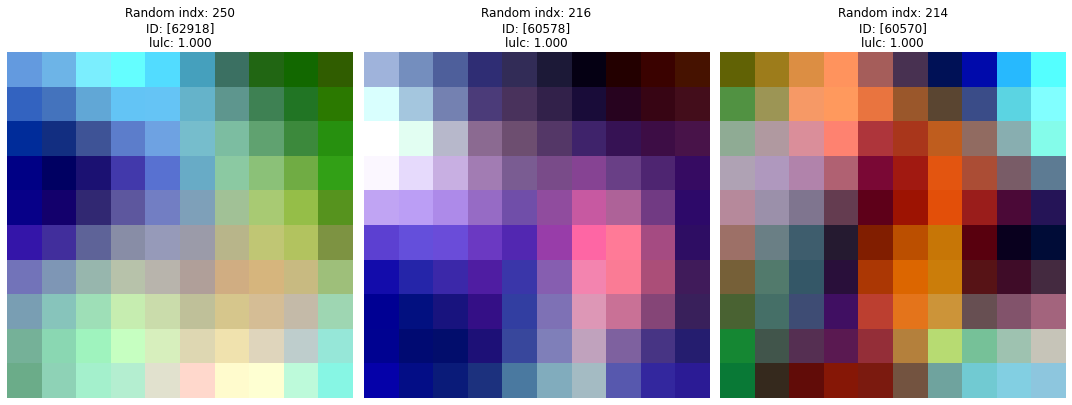

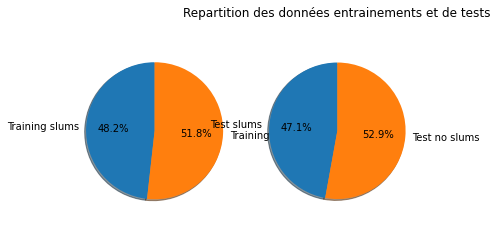

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1574. 2636. 3386. 2285.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_25963_1.tif'
[25963]
[1376. 1444. 1405. 2084.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_26685_1.tif'
[26685]
[2520. 3408. 3578. 2752.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_28725_1.tif'
[28725]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.5291528  -1.9802687 -13.543243 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_19617_1.tif'
[19617]
[  0.3504651  -8.011219  -12.712733 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_24935_1.tif'
[24935]
[ 0.67807835 -1.5760701  -7.389705  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_62405_1.tif'
[62405]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenat

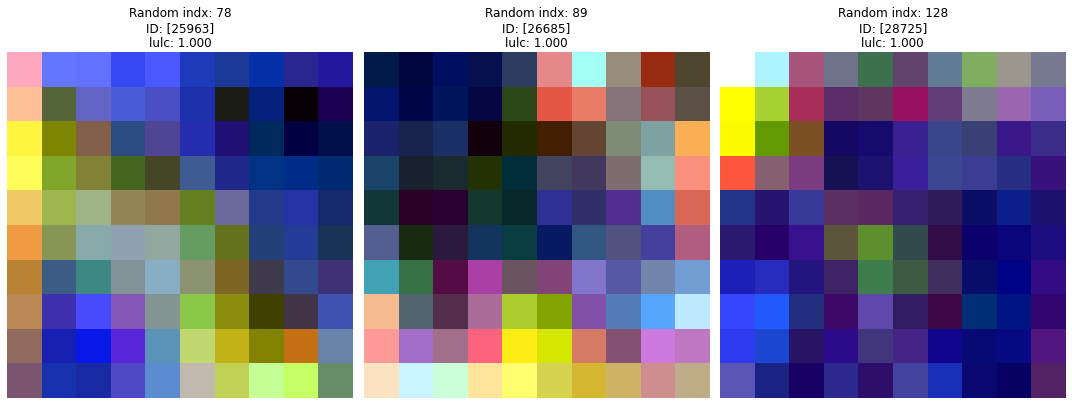

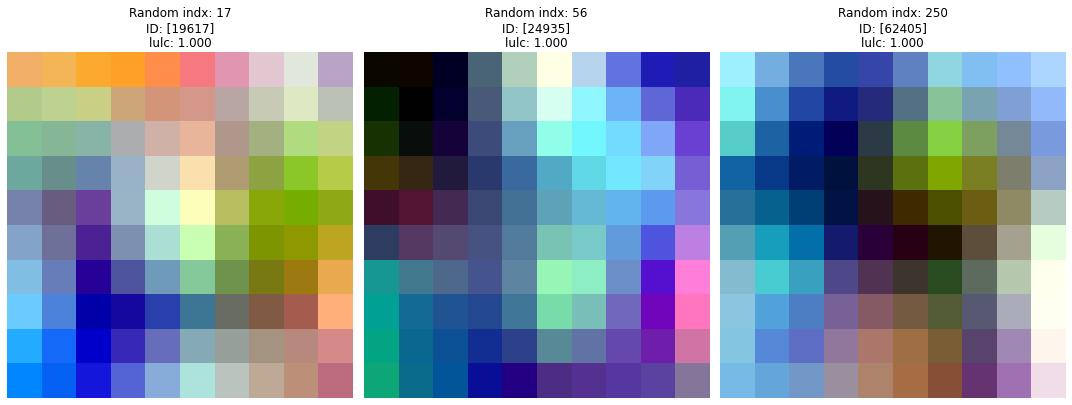

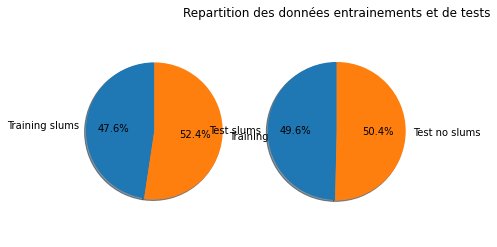

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1572. 1540. 1453. 2352.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_54564_1.tif'
[54564]
[1426. 1758. 2085. 2400.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_28976_1.tif'
[28976]
[1394. 1406. 1392. 2214.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_60639_1.tif'
[60639]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.649471   -1.8897724 -11.680624 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_54565_1.tif'
[54565]
[  0.53506833  -7.7887774  -13.34231   ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_59565_1.tif'
[59565]
[  0.55402213  -4.0143247  -18.381329  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_22159_1.tif'
[22159]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Conc

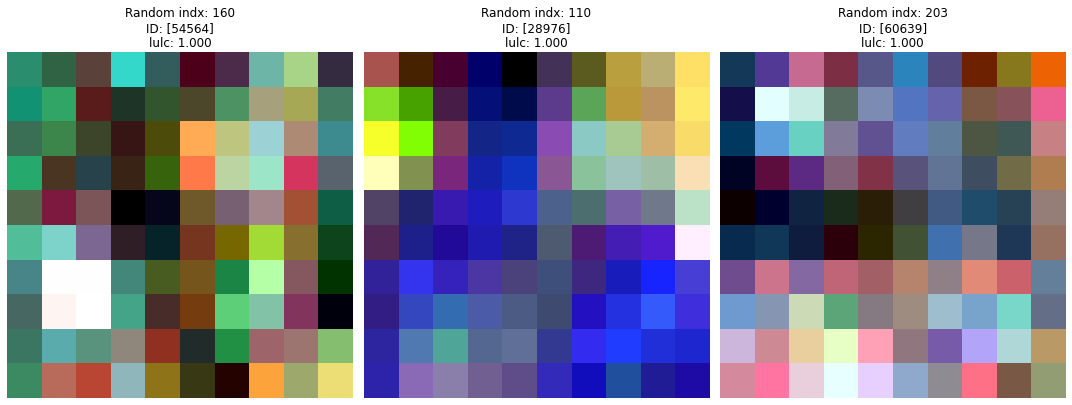

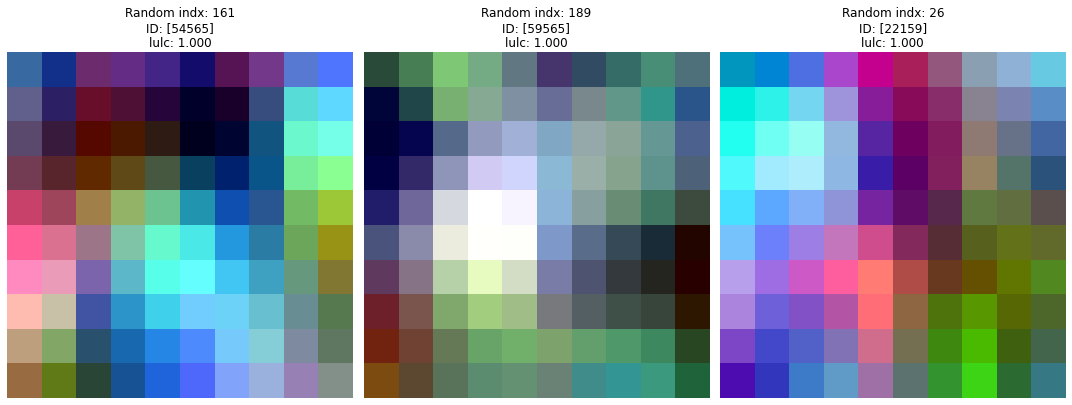

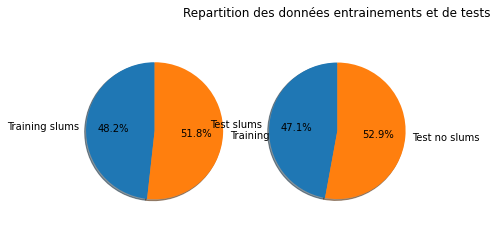

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1356. 1990. 2034. 2040.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_18097_1.tif'
[18097]
[1318. 1740. 1856. 2199.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_63857_1.tif'
[63857]
[1238. 1534. 1618. 2254.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_64368_1.tif'
[64368]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.42275628  -6.9404845  -11.61492   ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_62160_1.tif'
[62160]
[  0.41425717  -7.007625   -12.066826  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_12533_1.tif'
[12533]
[ 0.50000584 -5.4956574  -6.310621  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_63803_1.tif'
[63803]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Conc

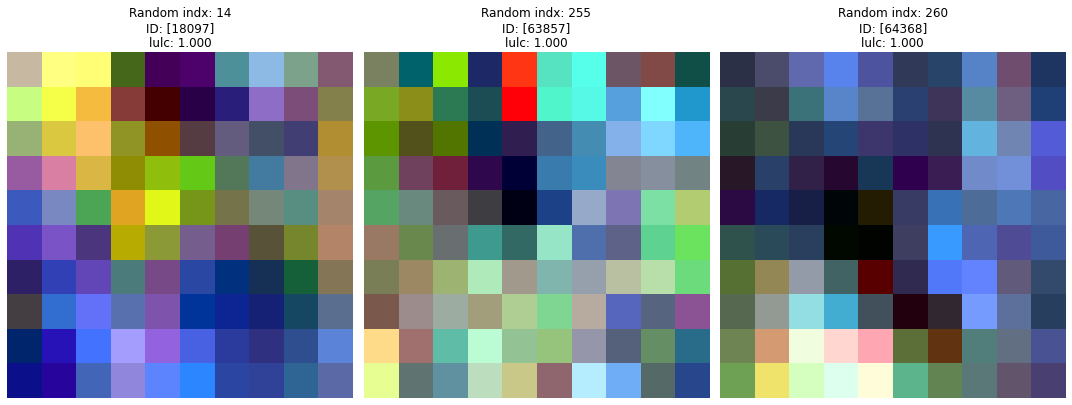

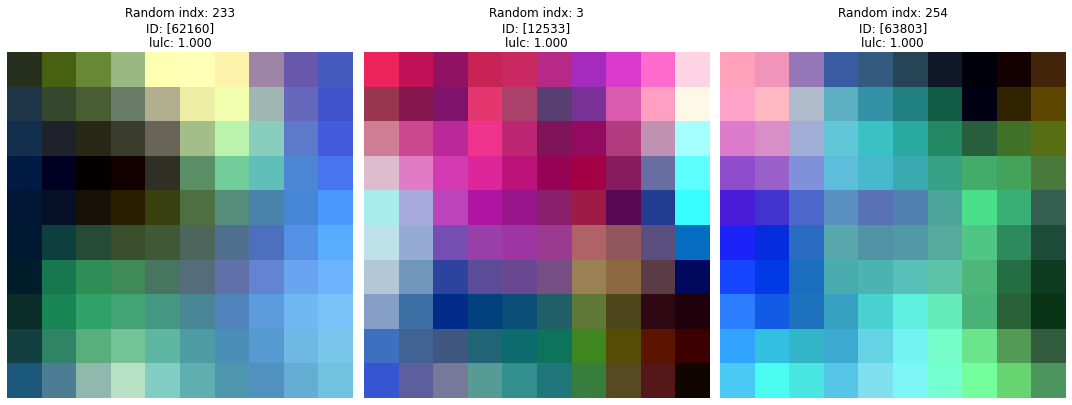

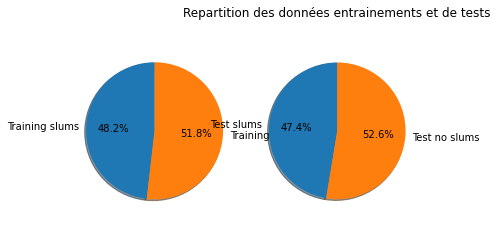

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1634. 2030. 1849. 2209.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_26706_1.tif'
[26706]
[1680. 1870. 1662. 2259.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_27721_1.tif'
[27721]
[1312. 1836. 2574. 2446.]
b'Images/big_raster/tr_RNIR_patch/tr_RNIR_64181_1.tif'
[64181]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.4084334 -10.746822  -14.8795   ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_28721_1.tif'
[28721]
[  0.59278077  -3.7926693  -10.882197  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_37101_1.tif'
[37101]
[  0.5125412  -3.5843668 -12.849848 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_27443_1.tif'
[27443]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concate

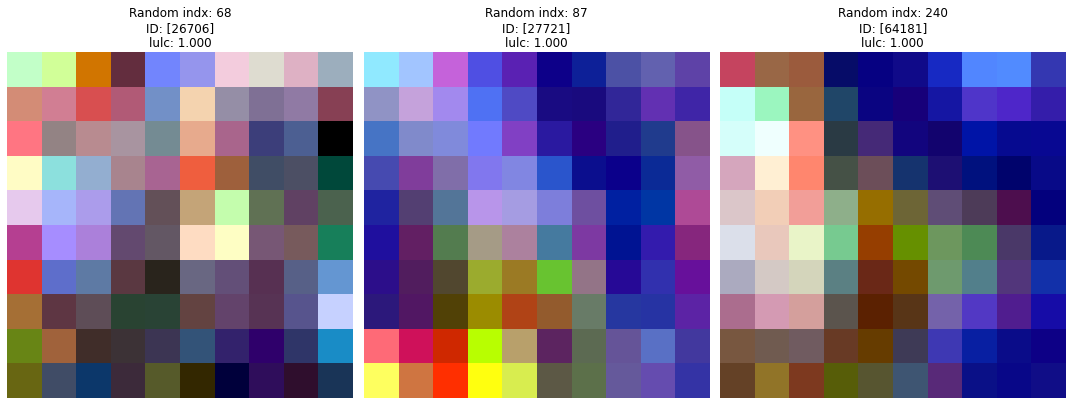

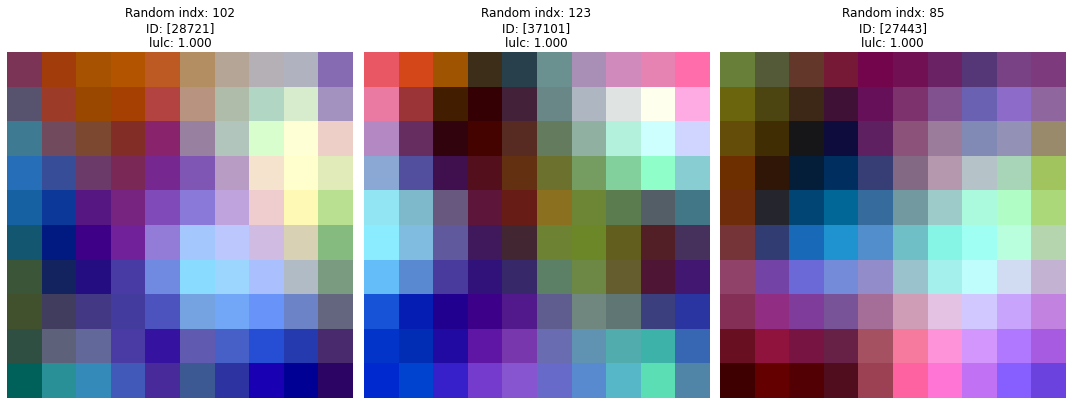

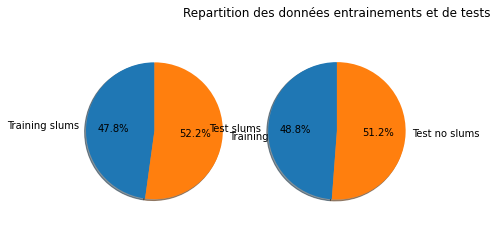

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1460. 1036.  735. 1776.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_20385_1.tif'
[20385]
[1576. 1138.  882. 1824.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_25169_1.tif'
[25169]
[1324. 1110.  949. 1470.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_60387_1.tif'
[60387]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.48602623 -10.11222    -15.148942  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_58801_1.tif'
[58801]
[  0.42446658  -7.4527497  -14.704815  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_27700_1.tif'
[27700]
[ 0.5830323 -3.7395365 -8.409627 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_39129_1.tif'
[39129]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concate

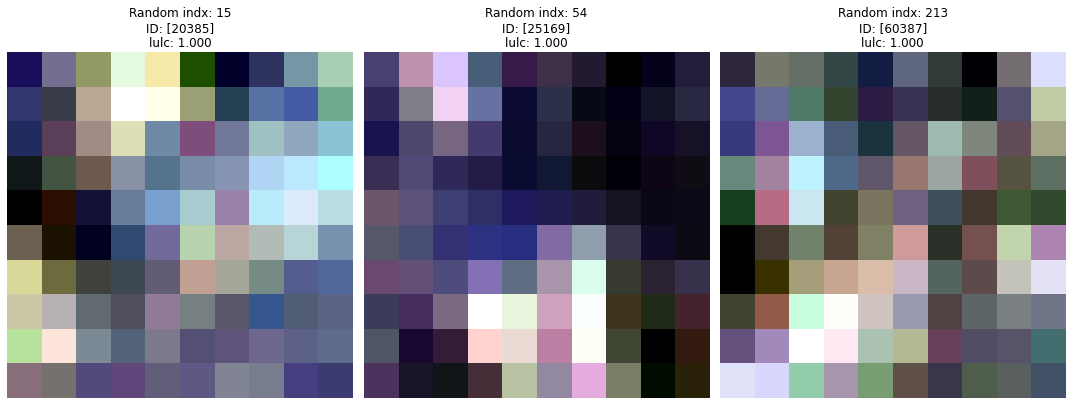

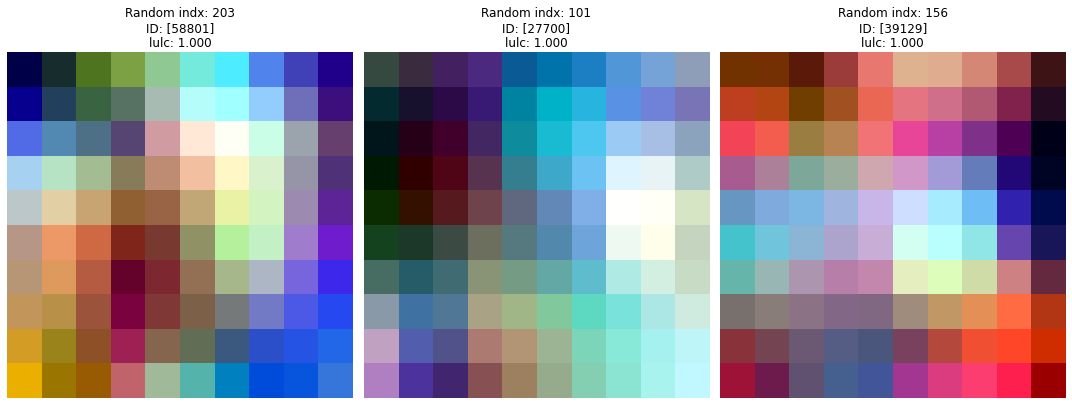

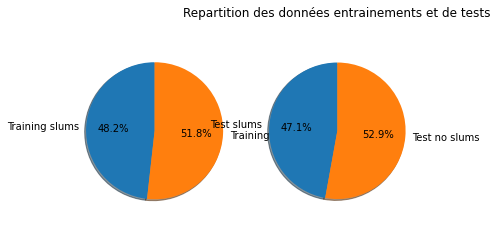

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1086.  761.  508. 2288.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_18860_1.tif'
[18860]
[1230.  767.  478. 1542.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_25711_1.tif'
[25711]
[1086.  761.  508. 2288.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_18860_1.tif'
[18860]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.56493366  -4.1822314  -10.410925  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_36351_1.tif'
[36351]
[  0.5306736  -3.5837042 -14.7255335]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_19623_1.tif'
[19623]
[  0.63516736  -3.8253903  -11.426375  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_55524_1.tif'
[55524]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Conc

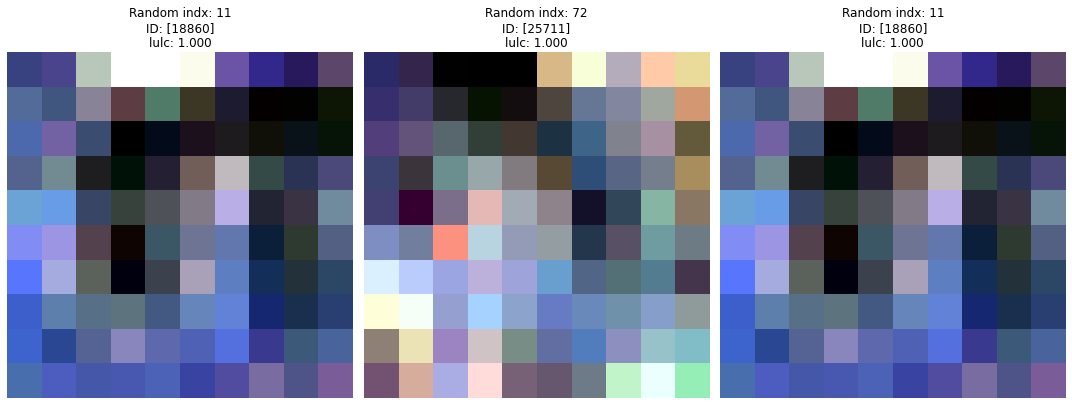

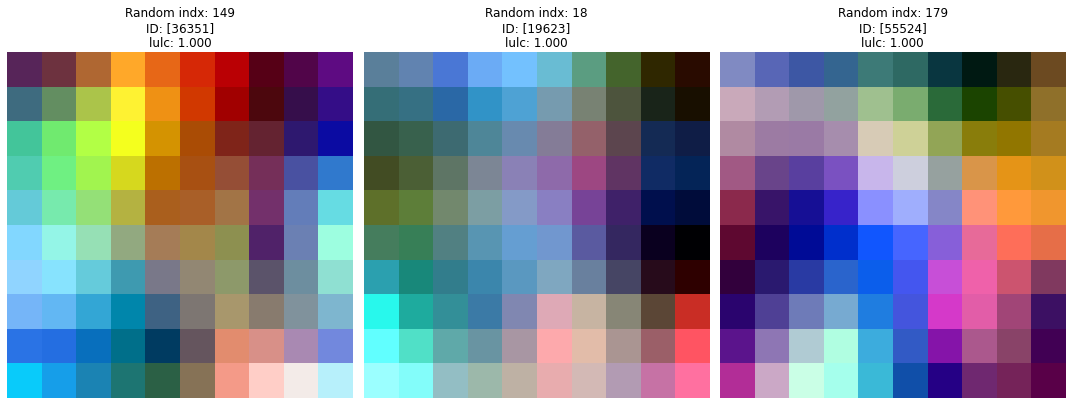

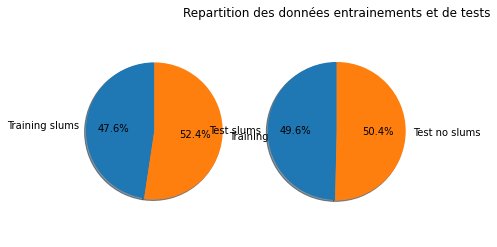

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1306. 1090.  841. 1804.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_24946_1.tif'
[24946]
[1540. 1280.  995. 1856.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_27442_1.tif'
[27442]
[1550. 1372. 1206. 1792.]
b'Images/big_raster/tr_RGBNIR_patch/tr_RGBNIR_55800_1.tif'
[55800]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.44073388  -5.365175   -13.179884  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_54797_1.tif'
[54797]
[ 0.55363  -8.005879 -8.852483]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_61080_1.tif'
[61080]
[  0.5935386  -0.680381  -10.780263 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_54033_1.tif'
[54033]
Model is ready to run
(None, 10, 10, 4)
(None, 10, 10, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenate) 

In [ ]:
for path in range(3) :
    print(IMAGESTR[path])
    
    f = h5py.File(IMAGESG[path], 'r')
    S1_grid_id = np.array(f["id_sar"])          
    S2_grid_id = np.array(f["id_rgb"])                     
    S1_grid_path = f["patch_sar_path"]
    S2_grid_path = f["patch_rgb_path"]
    
    S1_grid_id = S1_grid_id.reshape(S1_grid_id.size,1)
    S2_grid_id = S2_grid_id.reshape(S2_grid_id.size,1)
    
    f = h5py.File(IMAGESTR[path], 'r')
    S1_patch_id = list(f["id_sar"])
    S2_patch_id = np.array(f["id_rgb"])
    S1_patch_lulc = list(f["lulc_sar"])
    S2_patch_lulc = np.array(f["lulc_rgb"])
    S1_patch_path = list(f["patch_sar_path"])
    S2_patch_path = list(f["patch_rgb_path"])
    
    stack = stackage(S1_grid_path)
    S1_stack_grid = normalise_01(stack)

    stack = stackage(S2_grid_path)
    S2_stack_grid = normalise_01(stack)
    
    print('Images are imported and normalised')
    
    HIST = []
    PRED = []
    EVAL = []
    
    
    PREDALL.append(S1_grid_id)
    
    for fold in range(5):
        patch_id_train = data.ID_train[fold][1:-1].split(",")
        patch_id_test = data.ID_val[fold][1:-1].split(",")
        patch_lulc_train = []

        i = 0
        for id in patch_id_train :
            index = S1_patch_id.index(int(id))
            patch_id_train[i] = int(id)
            lulc = S1_patch_lulc[index]
            patch_lulc_train.append(lulc)
            i += 1
        patch_lulc_test = []
        i = 0

        for id in patch_id_test :
            index = S1_patch_id.index(int(id))
            patch_id_test[i] = int(id)
            lulc = S1_patch_lulc[index]
            patch_lulc_test.append(lulc)
            i += 1

        patch_id_train = reshape(patch_id_train)
        patch_id_test = reshape(patch_id_test)
        patch_lulc_train = reshape(patch_lulc_train)
        patch_lulc_test = reshape(patch_lulc_test) 

        circle(patch_lulc_train,patch_lulc_test,'Repartition des données entrainements et de tests')

        stack_train, stack_test = assimilation(patch_id_train, patch_id_test, patch_lulc_test, S2_patch_path)

        stack_sar_train, stack_sar_test = assimilation(patch_id_train, patch_id_test, patch_lulc_test, S1_patch_path)
        
        from keras import backend as K
        K.clear_session()

        left_input_shape = (10,10,4)
        right_input_shape = (10,10,3)
        batch_size = 32
        kernel_size = 2
        dropout = 0.5 #0.5 for previous tests
        n_filters = 32
        
        print('Model is ready to run')

        history, predict, layers, model, evaluation = ymodel(left_input_shape,right_input_shape,batch_size,kernel_size,dropout,n_filters,stack_train,stack_test,stack_sar_train,stack_sar_test,fold)

        HIST.append(history)
        PRED.append(predict)
        EVAL.append(evaluation)
        
        print('End of the model for the data '+str(IMAGENAME[path])+' and the fold number : '+str(fold+1))

        make_csv(predict, S1_grid_id,'outputCSV/y_S1S2_KFOLD_'+str(IMAGENAME[path])+'_'+str(fold+1))
        
    HISTALL.append(HIST)
    PREDALL.append(PRED)
    EVALALL.append(EVAL)


## **Plotting accuracy, loss and prediction range**

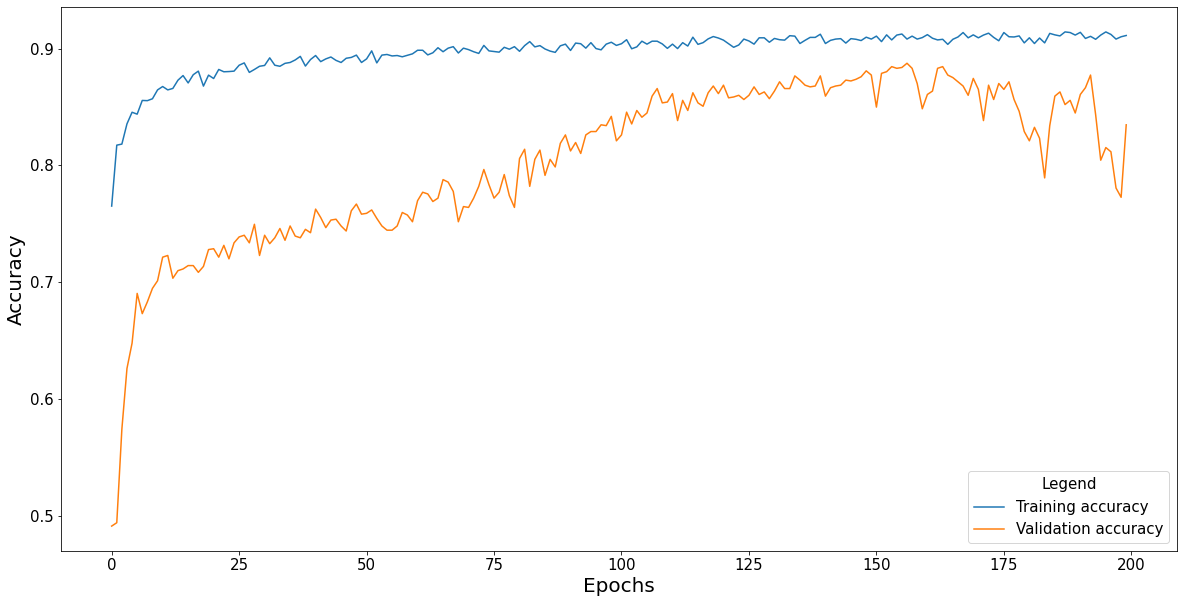

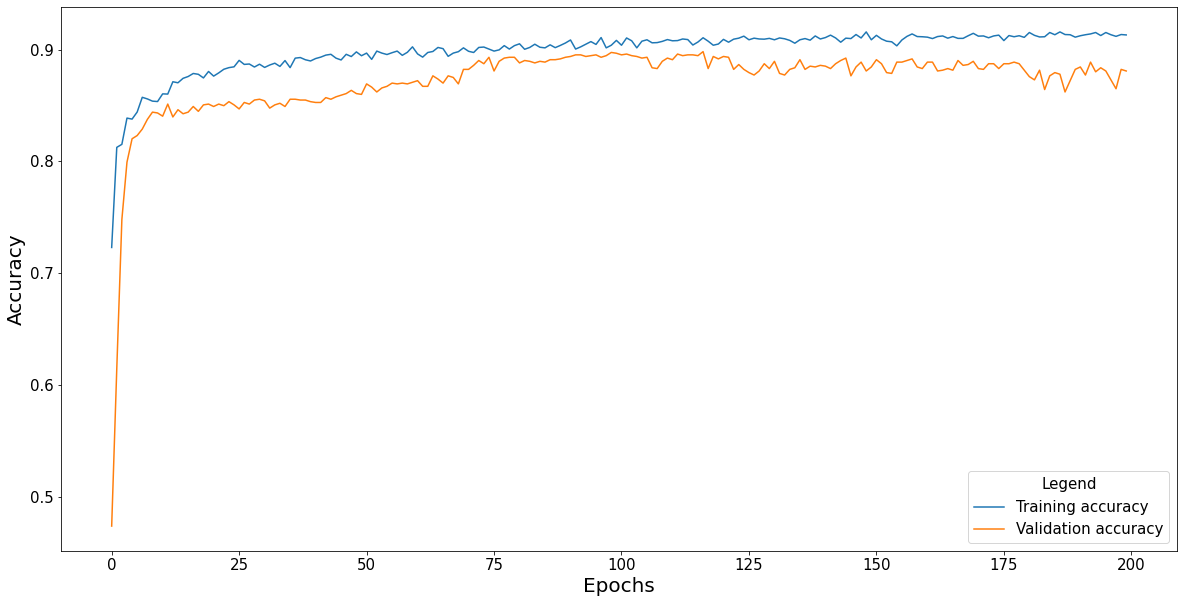

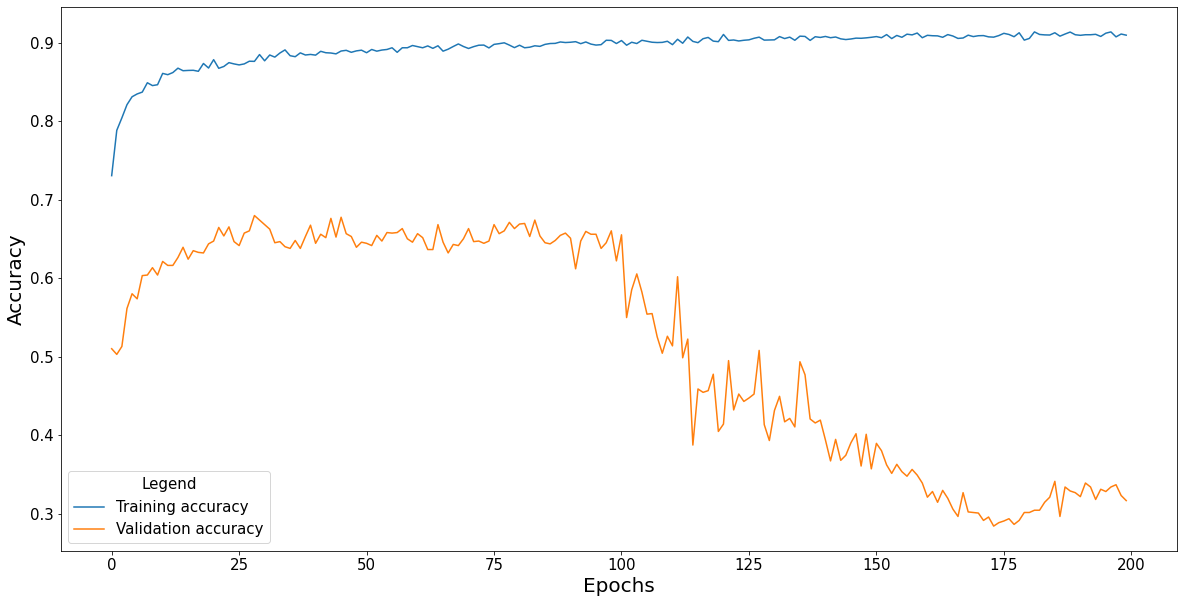

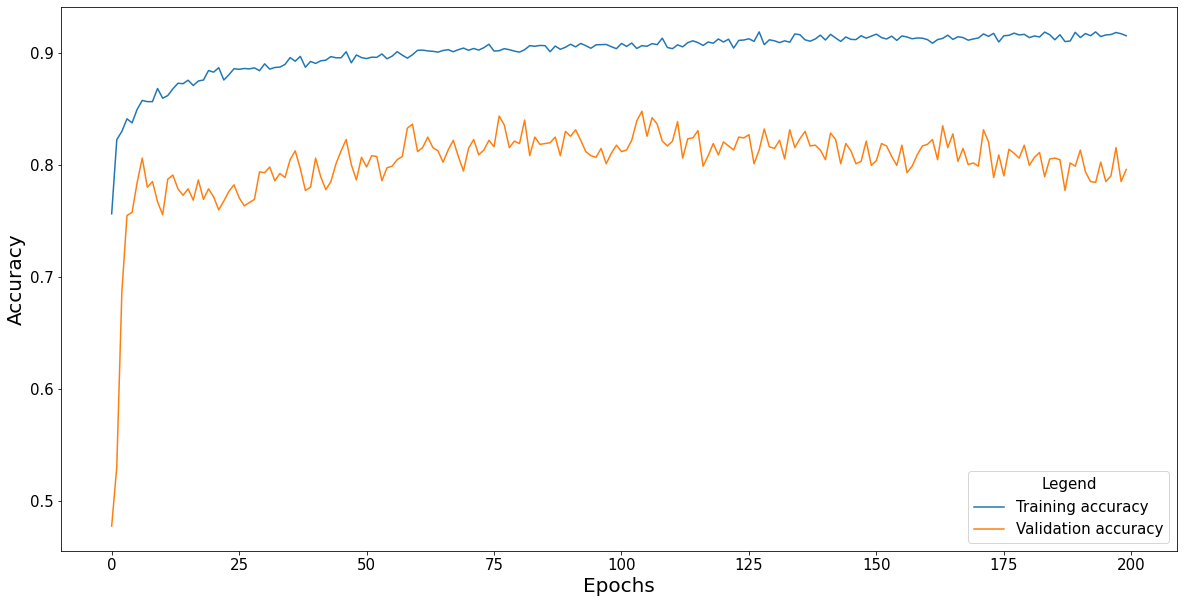

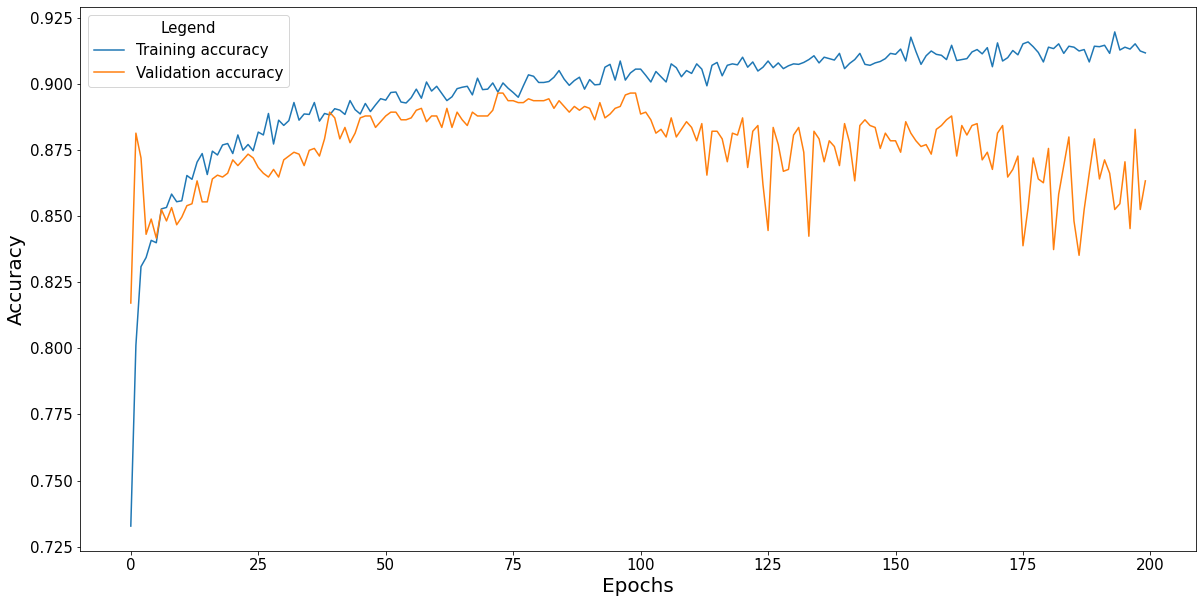

In [122]:
for history in HISTALL[2] :
    f = plt.figure(figsize = (20,10))
    plt.rc('font', size=15)    
    plt.rc('axes', labelsize=20)
    plt.rc('legend', fontsize=15)    # legend fontsize
    plt.rc('axes', titlesize=15)    # fontsize of the x and y labels   
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training accuracy','Validation accuracy'], title = "Legend")
    plt.show()

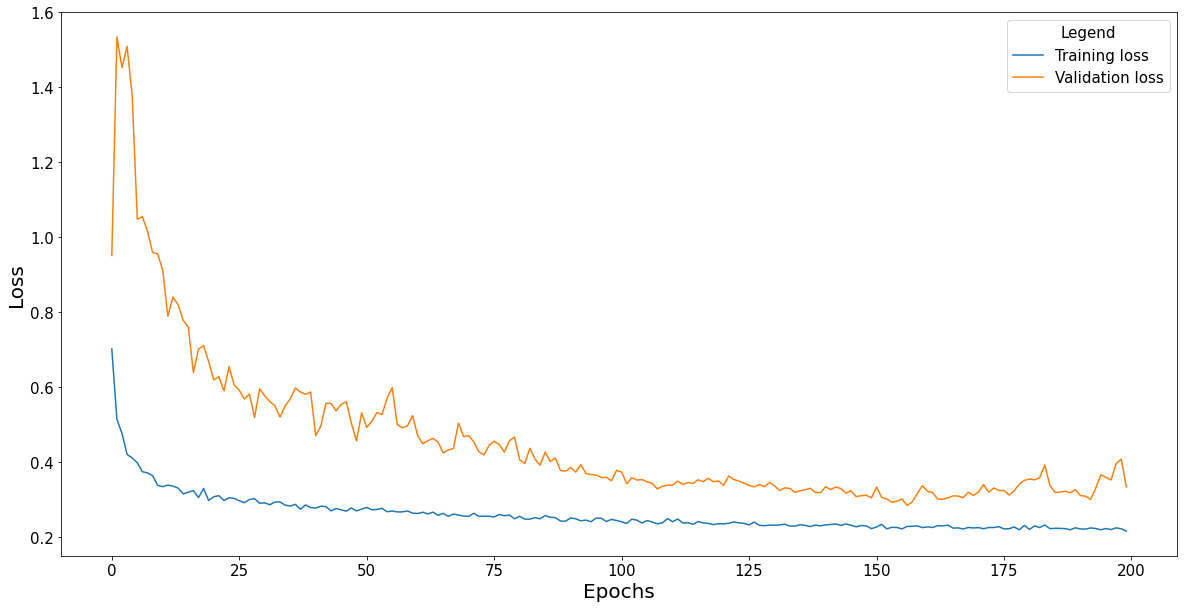

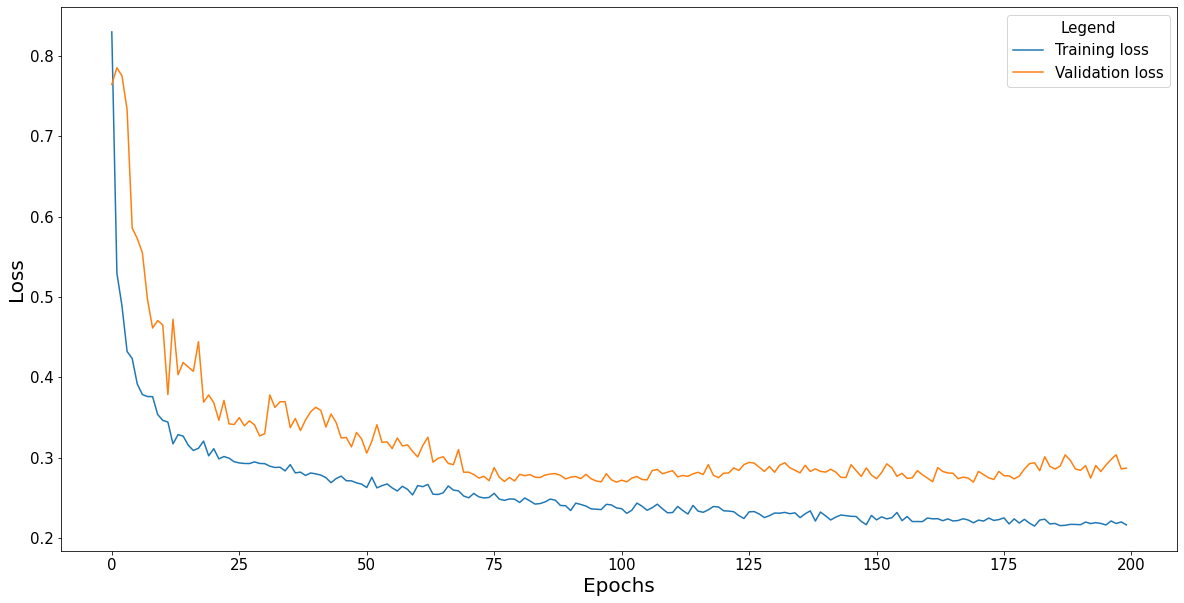

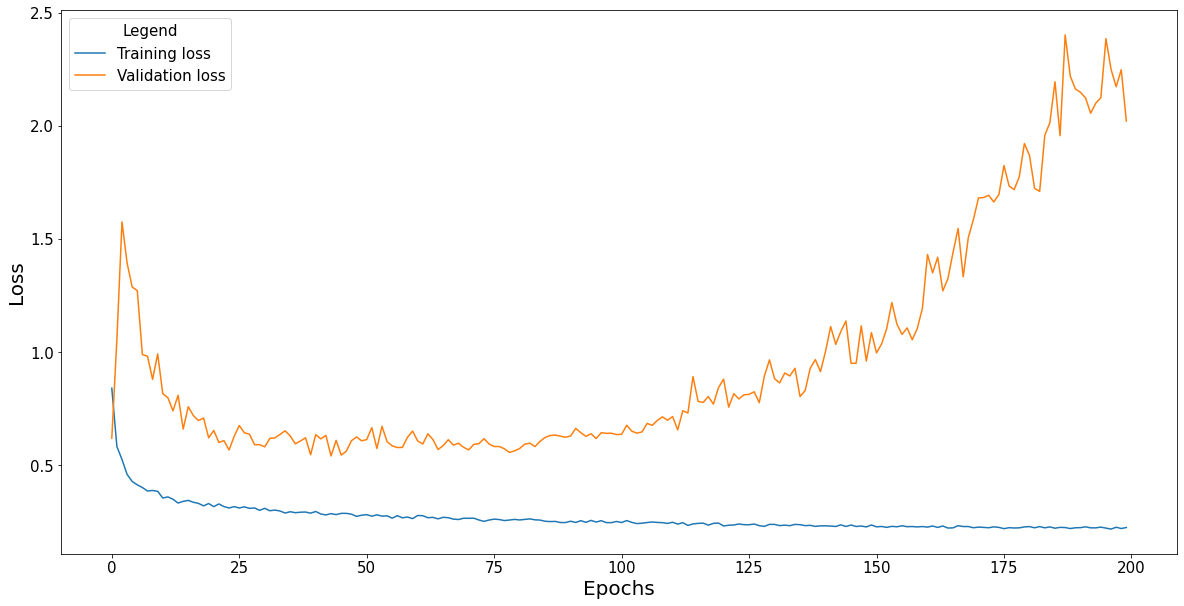

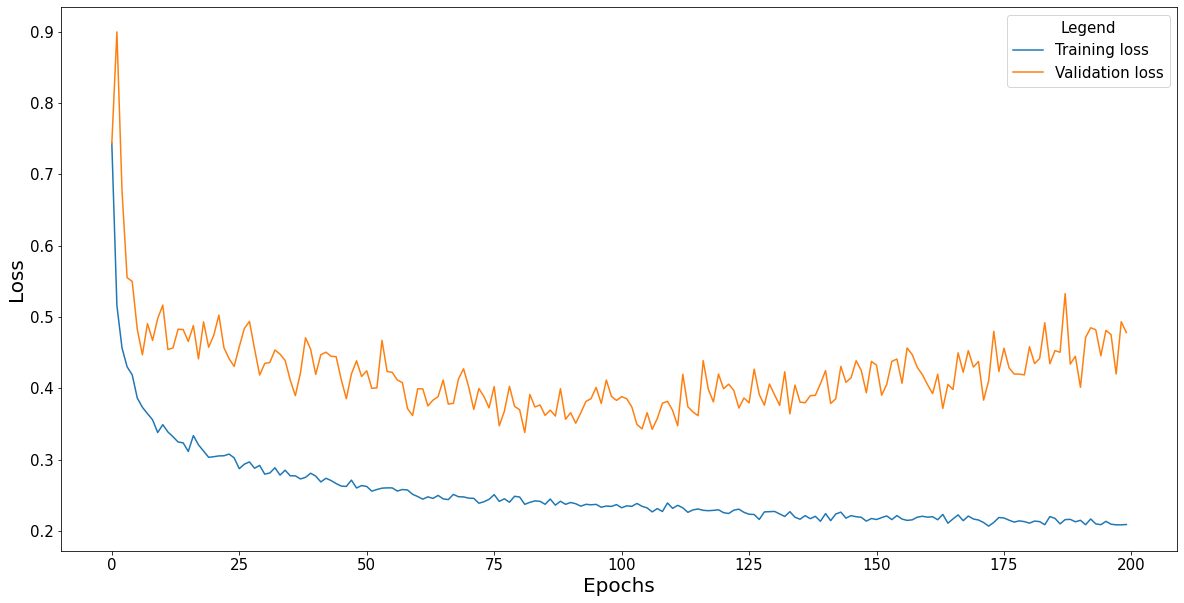

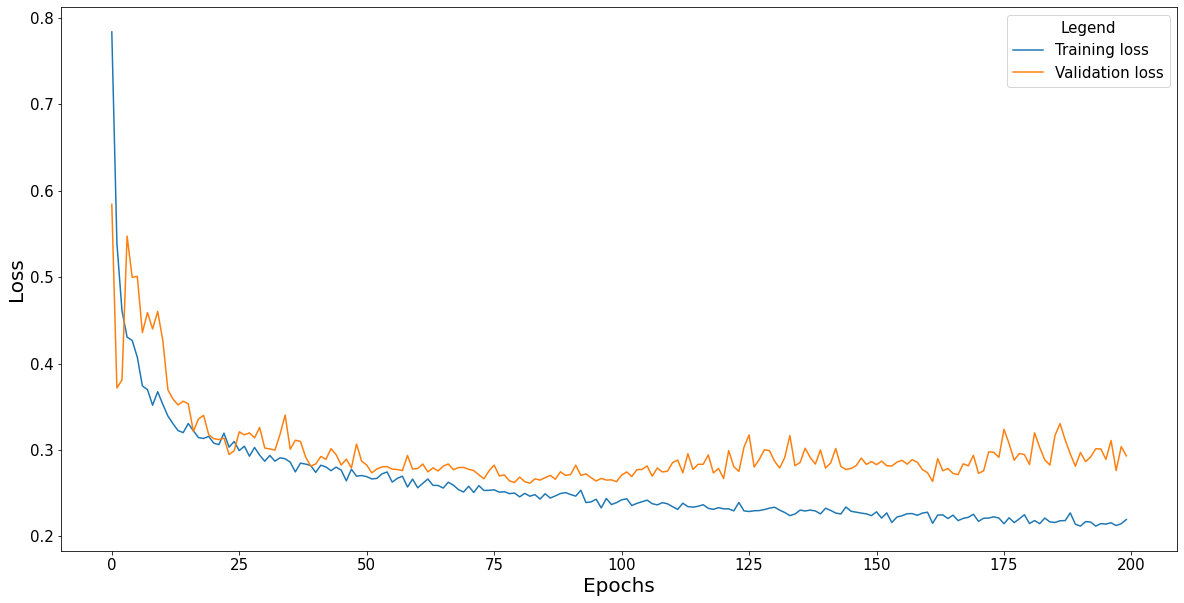

In [121]:
for history in HISTALL[2] :
    f = plt.figure(figsize = (20,10))
    plt.rc('font', size=15)    
    plt.rc('axes', labelsize=20)
    plt.rc('legend', fontsize=15)    # legend fontsize
    plt.rc('axes', titlesize=15)    # fontsize of the x and y labels
    plt.plot(history.history["loss"])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training loss','Validation loss'], title = "Legend")
    plt.show()

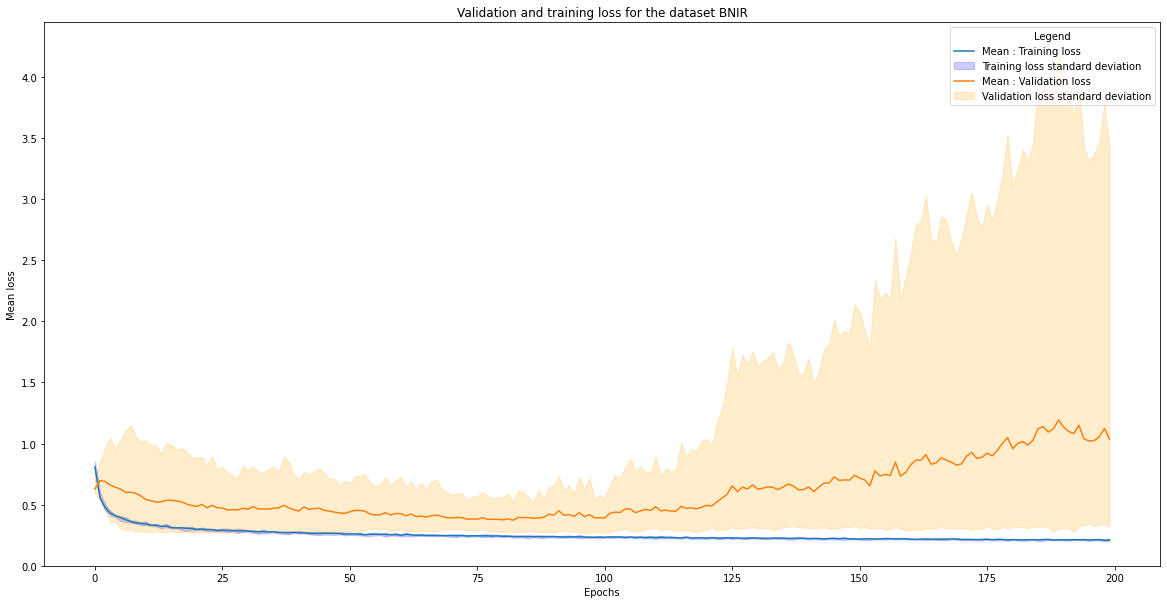

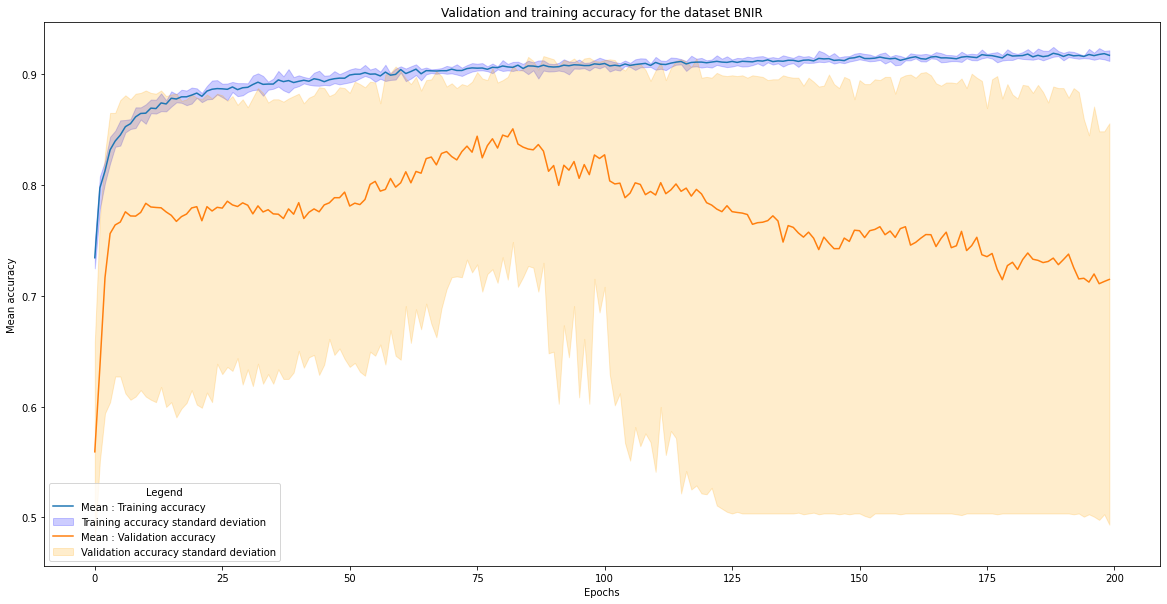

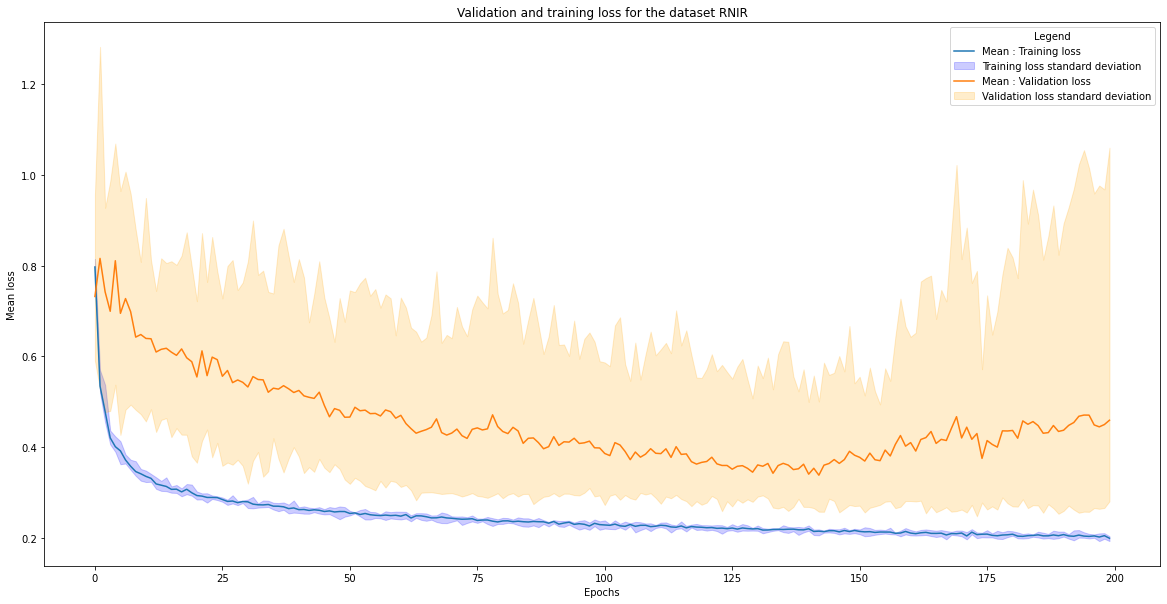

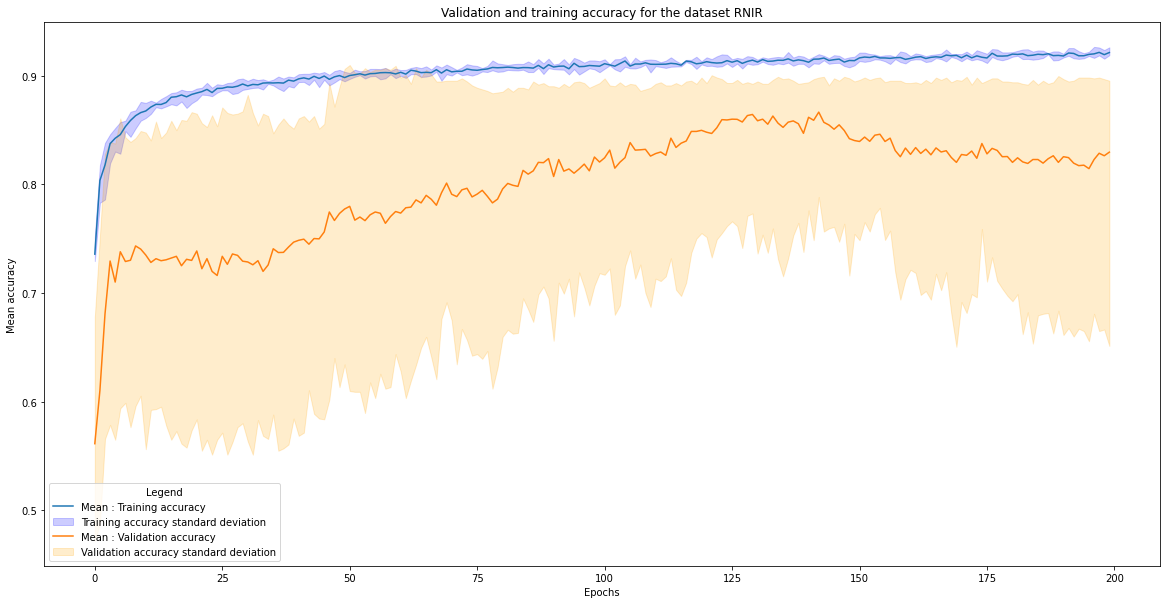

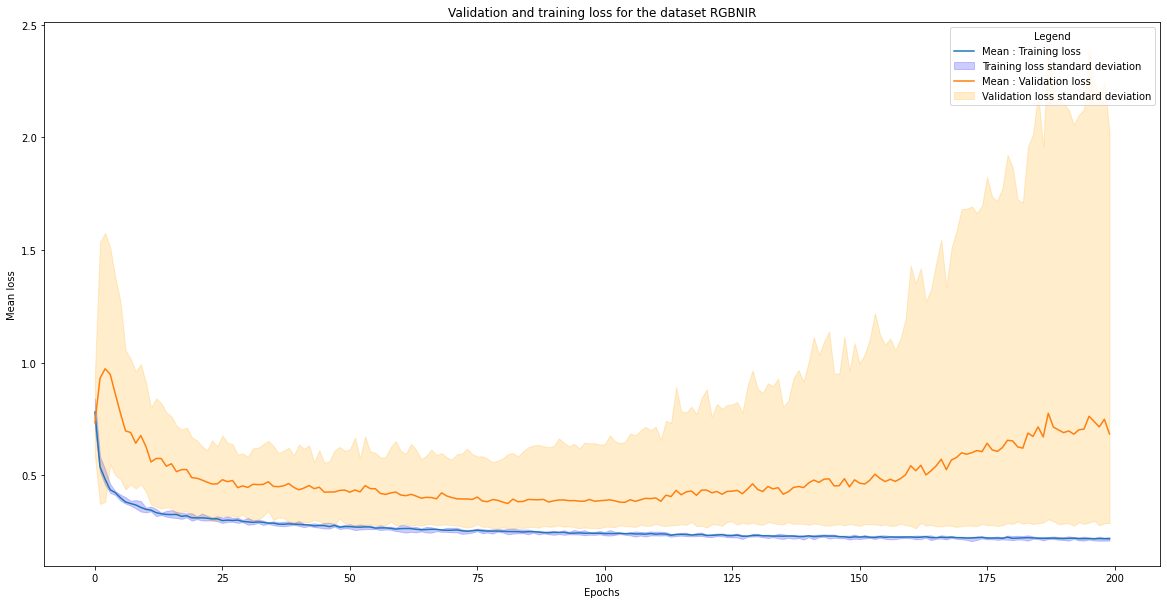

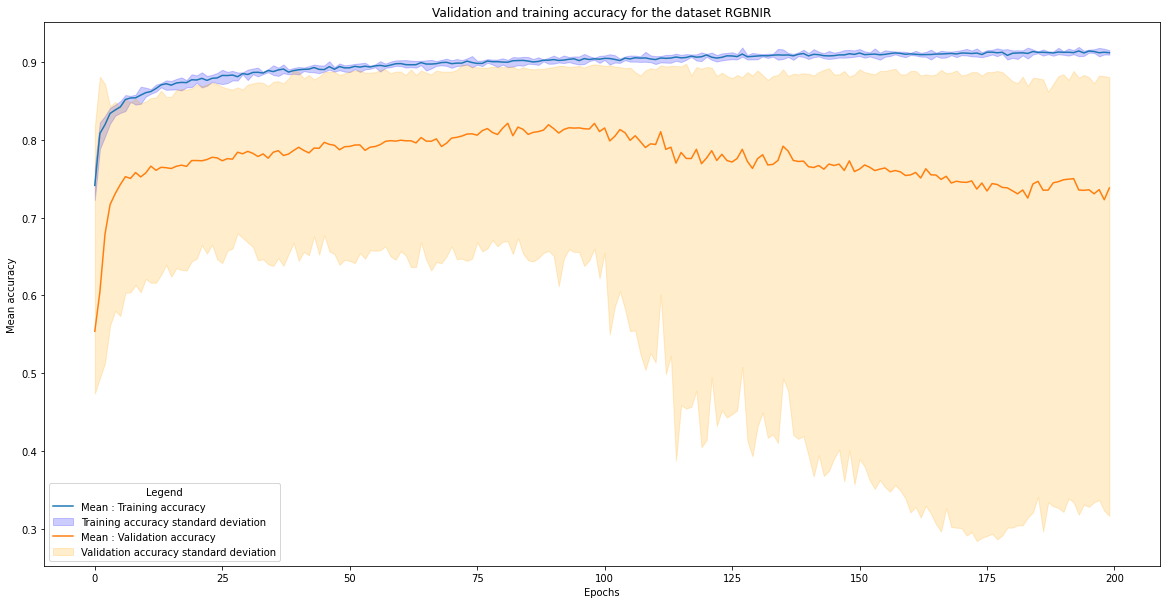

In [98]:
plotandcsv_history_kfold(HISTALL, 'ALL')

## **Exporting accuracy** of each kfold's predictions

In [99]:
output_accuracy = []
for i in range(len(EVALALL)) :
    EVAL = []
    somme = 0
    EVAL.append(IMAGENAME[i])
    for evaluation in EVALALL[i]: 
        EVAL.append(evaluation[1])
        somme += evaluation[1]
    std = np.std(EVAL[1:])
    EVAL.append(std)
    EVAL.append(somme/5)
    output_accuracy.append(EVAL)
print(output_accuracy)
output_accuracy = np.array(output_accuracy)


path_csv_kfold_output = '/home/jgovoort/outputCSV/YModelTest16_08VVVH.csv'
a = pd.DataFrame(output_accuracy, columns=['data','Kfold1','Kfold2','Kfold3','Kfold4','Kfold5','std','mean'])
a.to_csv(path_csv_kfold_output, index=False)

a

[['VVVH_BNIR', 0.9162454605102539, 0.90180504322052, 0.849711000919342, 0.7955202460289001, 0.897398829460144, 0.04435529624457345, 0.872136116027832], ['VVVH_RNIR', 0.8981949687004089, 0.8981949687004089, 0.9096820950508118, 0.8439306616783142, 0.8995664715766907, 0.023390442825130364, 0.8899138331413269], ['VVVH_RGBNIR', 0.8873646259307861, 0.8981949687004089, 0.6799132823944092, 0.8482658863067627, 0.8966763019561768, 0.08308628369136291, 0.8420830130577087]]


,data,Kfold1,Kfold2,Kfold3,Kfold4,Kfold5,std,mean
0,VVVH_BNIR,0.9162454605102539,0.90180504322052,0.849711000919342,0.7955202460289001,0.897398829460144,0.04435529624457345,0.872136116027832
1,VVVH_RNIR,0.8981949687004089,0.8981949687004089,0.9096820950508118,0.8439306616783142,0.8995664715766907,0.023390442825130364,0.8899138331413269
2,VVVH_RGBNIR,0.8873646259307861,0.8981949687004089,0.6799132823944092,0.8482658863067627,0.8966763019561768,0.08308628369136291,0.8420830130577087


## Average and calculate the standart deviation of the results of the Kfold

In [90]:
NAME = ['VVVH_BNIR','VVVH_RNIR','VVVH_RGBNIR']
for name in NAME :
    TOMEAN = []
    ID = []
    for i in range(1,6):
        filename = 'outputCSV/y_S1S2_KFOLD_'+name+'_'+str(i)+'.csv'
        print(filename)
        with open(filename) as file : 
            linecount = 0
            FOLD = []
            csvread = csv.reader(file, delimiter=',')
            for row in csvread :
                if linecount > 0 :
                    FOLD.append(float(row[0]))
                    if i == 1 :
                        ID.append(int(row[1]))
                linecount += 1
        TOMEAN.append(FOLD)
    TOMEAN = np.array(TOMEAN)

    MEAN = list(np.mean(TOMEAN, axis=0))
    STD = list(np.std(TOMEAN, axis=0))
    outmean = []
    outmean.append(MEAN)
    outmean.append(STD)
    outmean.append(ID)
    outmean = np.array(outmean).transpose()
    print(outmean.shape)


    path_csv_output = '/home/jgovoort/outputCSV/MEAN_STD_'+name+'.csv'
    a = pd.DataFrame(outmean, columns=['MEAN','STD','id'])
    a.to_csv(path_csv_output, index=False)
    a

outputCSV/y_S1S2_KFOLD_VVVH_BNIR_1.csv
outputCSV/y_S1S2_KFOLD_VVVH_BNIR_2.csv
outputCSV/y_S1S2_KFOLD_VVVH_BNIR_3.csv
outputCSV/y_S1S2_KFOLD_VVVH_BNIR_4.csv
outputCSV/y_S1S2_KFOLD_VVVH_BNIR_5.csv
(66399, 3)
outputCSV/y_S1S2_KFOLD_VVVH_RNIR_1.csv
outputCSV/y_S1S2_KFOLD_VVVH_RNIR_2.csv
outputCSV/y_S1S2_KFOLD_VVVH_RNIR_3.csv
outputCSV/y_S1S2_KFOLD_VVVH_RNIR_4.csv
outputCSV/y_S1S2_KFOLD_VVVH_RNIR_5.csv
(66399, 3)
outputCSV/y_S1S2_KFOLD_VVVH_RGBNIR_1.csv
outputCSV/y_S1S2_KFOLD_VVVH_RGBNIR_2.csv
outputCSV/y_S1S2_KFOLD_VVVH_RGBNIR_3.csv
outputCSV/y_S1S2_KFOLD_VVVH_RGBNIR_4.csv
outputCSV/y_S1S2_KFOLD_VVVH_RGBNIR_5.csv
(66399, 3)


## Garbage zone

0.03322613461096709
0.8057788862271519
0.8232369638696551
0.8327371771732354
0.8402520263840121
0.8458307354051128
0.8498014635907196
0.853542480228399
0.8565943622222951
0.8592196370557543
0.8616808322121222
0.8639123158205625
0.865503888688347
0.867423620910314
0.8689987858103895
0.8704755029042103
0.8718537721917763
0.8731335936730876
0.8745610868637811
0.8756276047648738
0.8768746103107669
0.8779411282118597
0.8792537656285893
0.8803530994651002
0.8815344731401569
0.8826009910412497
0.8835362452006694
0.8845371312309257
0.8856200570997276
0.8866045351622748
0.887605421192531
0.8884750434811144
0.889377481705116
0.8905096314770452
0.8915925573458472
0.8926426672792308
0.8935943294063597
0.8946772552751616
0.8957929970793818
0.8965477635940012
0.897614281495094
0.8984018639451318
0.8994847898139336
0.9004200439733535
0.9013881140681915
0.9021592885505201
0.9031273586453582
0.9041446526433236
0.9050634988350343
0.9061628326715453
0.9071309027663833
0.9078856692810029
0.908706067666458

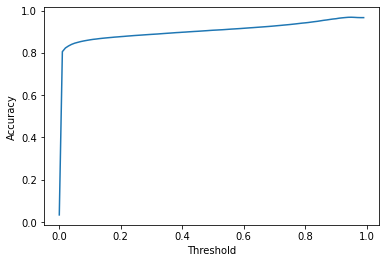

In [85]:
import csv
from sklearn.metrics import accuracy_score

VAL = []
VAL_id = []

with open('Images/test_sample/validation.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line = 0
    for row in csv_reader:
        if line >= 1 :
            VAL.append(float(row[2]))
            VAL_id.append(int(row[1]))
        line += 1


PROB = [None]*len(VAL)
PROB_id = [None]*len(VAL)

with open('outputCSV/y_S1S2_KFOLD_BNIR_1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line = 0
    for row in csv_reader:
        if line >= 1 :
            prob_id = int(row[1])
            verif = prob_id in VAL_id
            if verif == True :
                index = VAL_id.index(prob_id)
                PROB[index]= float(row[0])
                PROB_id[index] = prob_id
        line += 1

        



        
listthres = list(np.arange(0, 1.0, 0.01))

TOTACC = []

for threshold in listthres :
    pred = np.asarray(PROB)
    binary = np.where(pred>=threshold,1,0)

    
    acc = accuracy_score(VAL, binary)
                
    print(acc)
    TOTACC.append(acc)
                 
plt.plot(listthres,TOTACC)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
#plt.title('Validation and training accuracy for the dataset '+str(IMAGENAME[idx]))
#plt.legend(['Mean : Training accuracy','Training accuracy standard deviation','Mean : Validation accuracy', 'Validation accuracy standard deviation'], title = "Legend")
plt.show()

In [ ]:
from osgeo import ogr

diff = []
diff.append(['id','diff'])
mach_res = ogr.Open('CLUSTERS/nairobi_grid100_clust_morpho_10pc_10cl.shp')
mach_layer = mach_res.GetLayer()
for mach_patch in mach_layer :
    probstab = mach_patch.GetField('probstab')
    mach_id = mach_patch.GetField('id')
    index = S1_grid_id.index(mach_id)
    if probstab != None :
        line = [int(mach_id),predict[index,0] - probstab]
        diff.append(line)
    else :
        line = [int(mach_id),None]
        diff.append(line)

In [ ]:
import csv

name = 'machVSdeep2'

with open(str(name)+'.csv','w') as file :
    write = csv.writer(file)
    write.writerows(diff)

In [ ]:
print(diff)

In [ ]:
import os, signal

os.kill(os.getpid() , signal.SIGKILL)